In [125]:
import os
import anndata
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import scvi
import json

# ----------------- paths / settings -----------------
DATA_DIR = "./data_input"
TEST_PATH  = os.path.join(DATA_DIR, "pancreas_test.h5ad")
HVG_PATH   = os.path.join(DATA_DIR, "hvg_list.json")
FEDERATED_STATE_DICT = os.path.join("model_federated", "model.pt")
CENTRALIZED_FOLDER = os.path.join("model_centralized")

In [126]:
# load hvg list
with open(HVG_PATH) as f: hvg_list = json.load(f)

# load test data
adata_test = anndata.read_h5ad(TEST_PATH)
adata_test = adata_test[:, hvg_list].copy()

## Batch effects in original gene expression

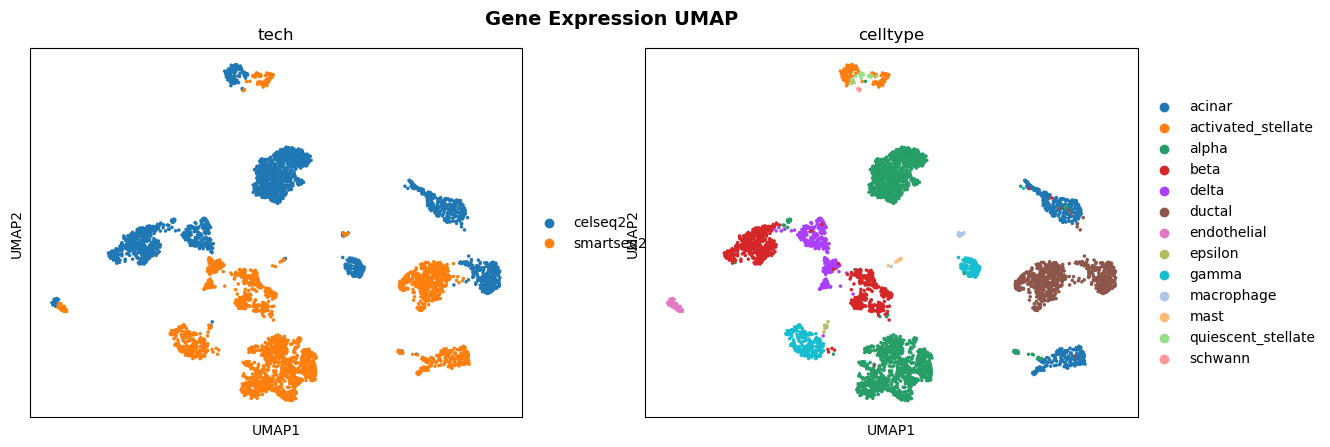

In [127]:
# Set raw counts as the working matrix
adata_test.X = adata_test.layers["counts"].copy()

# Basic preprocessing on expression for plotting
sc.pp.normalize_total(adata_test, target_sum=1e4)
sc.pp.log1p(adata_test)
sc.pp.scale(adata_test, max_value=10) 

# Dimensionality reduction and UMAP
sc.tl.pca(adata_test, n_comps=50)
sc.pp.neighbors(adata_test, n_pcs=50)
sc.tl.umap(adata_test)

sc.pl.umap(adata_test, color=["tech", "celltype"], show=False)
plt.suptitle("Gene Expression UMAP", fontsize=14, fontweight="bold")
plt.show()

## Batch effects in latent representation using centralized model

INFO     File model_centralized/model.pt already downloaded                                                        
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File model_centralized/model.pt already downloaded                                                        


/Users/dmalpetti/miniconda3/envs/fl-course-env/lib/python3.11/site-packages/scvi/model/base/_archesmixin.py:105: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  _, _, device = parse_device_args(
/Users/dmalpetti/miniconda3/envs/fl-course-env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/Users/dmalpetti/miniconda3/envs/fl-course-env/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accel

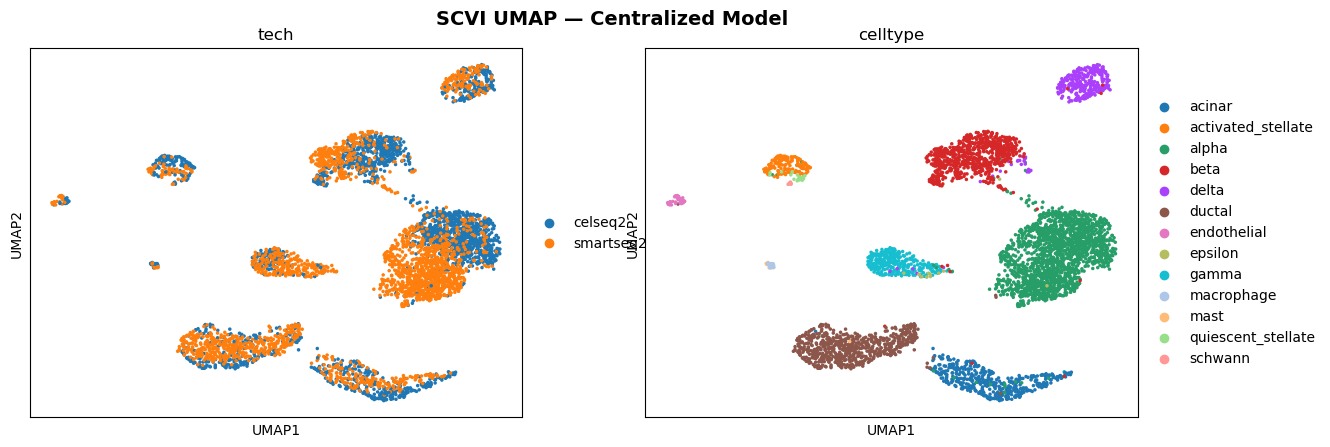

In [128]:
scvi.model.SCVI.prepare_query_anndata(adata_test, CENTRALIZED_FOLDER)
scvi_test = scvi.model.SCVI.load_query_data(adata_test, CENTRALIZED_FOLDER)

scvi_test.train(max_epochs=0, plan_kwargs={"weight_decay": 0.0})
adata_test.obsm["X_scVI_centralized"] = scvi_test.get_latent_representation()

# Neighbors/UMAP on the scVI latents
sc.pp.neighbors(adata_test, use_rep="X_scVI_centralized")
sc.tl.leiden(adata_test)
sc.tl.umap(adata_test)

sc.pl.umap(adata_test, color=["tech", "celltype"], show=False)
plt.suptitle("SCVI UMAP — Centralized Model", fontsize=14, fontweight="bold")
plt.show()

## Batch effects in latent representation using centralized model

In [ ]:
scvi_model = scvi.model.SCVI(adata_test, use_layer_norm="both", use_batch_norm="none", encode_covariates=True, dropout_rate=0.2, n_layers=2)
state = torch.load(FEDERATED_STATE_DICT, map_location="cpu")
scvi_model.module.load_state_dict(state)  # load into underlying torch module
scvi_model.is_trained = True              # silence "not trained" warnings

# ----------------- latents 
with torch.inference_mode():
    adata_test.obsm["X_scVI_federated"] = scvi_model.get_latent_representation()

# ----------------- UMAP 
sc.pp.neighbors(adata_test, use_rep="X_scVI_federated")
sc.tl.leiden(adata_test)
sc.tl.umap(adata_test)

sc.pl.umap(adata_test, color=["tech", "celltype"], show=False)
plt.suptitle("SCVI UMAP — Federated Model", fontsize=14, fontweight="bold")
plt.show()